In [1]:
####Source: https://curiousily.com/posts/multi-label-text-classification-with-bert-and-pytorch-lightning/

import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy, f1, auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

/root/Aditya/venv/lib/python3.6/site-packages/pytorch_lightning/metrics/__init__.py:44: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  "`pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package"


In [2]:
df = pd.read_csv('intent_data_model.csv',encoding='latin1')

train_df, val_df = train_test_split(df, test_size=0.15,random_state=1 )
train_df.shape, val_df.shape

((680, 14), (121, 14))

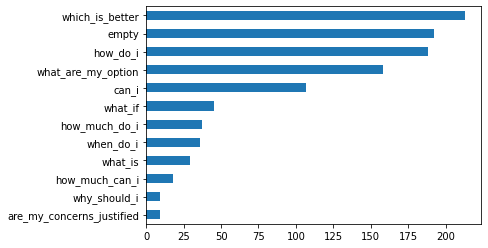

In [3]:
LABEL_COLUMNS = df.columns.tolist()[2:]
df[LABEL_COLUMNS].sum().sort_values().plot(kind="barh");

In [4]:
BERT_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

In [5]:
sample_row = df.iloc[16]
sample_comment = sample_row.question
sample_labels = sample_row[LABEL_COLUMNS]

In [6]:
encoding = tokenizer.encode_plus(
  sample_comment,
  add_special_tokens=True,
  max_length=512,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)
print(encoding.keys())
print(encoding["input_ids"].shape, encoding["attention_mask"].shape)

dict_keys(['input_ids', 'attention_mask'])
torch.Size([1, 512]) torch.Size([1, 512])


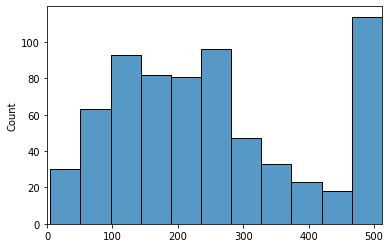

In [7]:
token_counts = []
for _, row in train_df.iterrows():
    token_count = len(tokenizer.encode(
    row["question"],
    max_length=512,
    truncation=True
  ))
    token_counts.append(token_count)
sns.histplot(token_counts)
plt.xlim([0, 512]);

In [8]:
MAX_TOKEN_COUNT = 256

In [9]:
class IntentDataset(Dataset):
    def __init__(self,data: pd.DataFrame,tokenizer: BertTokenizer,max_token_len: int = 128):
        self.tokenizer = tokenizer
        self.data = data
        self.max_token_len = max_token_len
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index: int):
        data_row = self.data.iloc[index]
        comment_text = data_row.question
        labels = data_row[LABEL_COLUMNS]
        encoding = self.tokenizer.encode_plus(comment_text,add_special_tokens=True,max_length=self.max_token_len,
                                              return_token_type_ids=False,padding="max_length",truncation=True,
                                              return_attention_mask=True,return_tensors='pt')
        return dict(comment_text=comment_text,
                    input_ids=encoding["input_ids"].flatten(),
                    attention_mask=encoding["attention_mask"].flatten(),
                    labels=torch.FloatTensor(labels))

In [10]:
train_dataset = IntentDataset(train_df,tokenizer,max_token_len=MAX_TOKEN_COUNT)

In [11]:
bert_model = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
sample_batch = next(iter(DataLoader(train_dataset, batch_size=8, num_workers=0)))
sample_batch["input_ids"].shape, sample_batch["attention_mask"].shape

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


(torch.Size([8, 256]), torch.Size([8, 256]))

In [12]:
output = bert_model(sample_batch["input_ids"], sample_batch["attention_mask"])
output.last_hidden_state.shape, output.pooler_output.shape


(torch.Size([8, 256, 768]), torch.Size([8, 768]))

In [13]:
class IntentDataModule(pl.LightningDataModule):
    def __init__(self, train_df, test_df, tokenizer, batch_size=8, max_token_len=128):
        super().__init__()
        self.batch_size = batch_size
        self.train_df = train_df
        self.test_df = test_df
        self.tokenizer = tokenizer
        self.max_token_len = max_token_len
    def setup(self, stage=None):
        self.train_dataset = IntentDataset(self.train_df,self.tokenizer,self.max_token_len)
        self.test_dataset = IntentDataset(self.test_df,self.tokenizer,self.max_token_len)
    def train_dataloader(self):
        return DataLoader(self.train_dataset,batch_size=self.batch_size,shuffle=True,num_workers=10)
    def val_dataloader(self):
        return DataLoader(self.test_dataset,batch_size=self.batch_size,num_workers=10)
    def test_dataloader(self):
        return DataLoader(self.test_dataset,batch_size=self.batch_size,num_workers=10)

In [14]:
N_EPOCHS = 100
BATCH_SIZE = 12
data_module = IntentDataModule(train_df,val_df,tokenizer,batch_size=BATCH_SIZE,max_token_len=MAX_TOKEN_COUNT)

In [15]:
class IntentTagger(pl.LightningModule):
    def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
        super().__init__()
        self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
        self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.n_training_steps = n_training_steps
        self.n_warmup_steps = n_warmup_steps
        self.criterion = nn.BCELoss()
    
    def forward(self, input_ids, attention_mask, labels=None):
        output = self.bert(input_ids, attention_mask=attention_mask)
        output = self.classifier(output.pooler_output)
        output = torch.sigmoid(output)
        loss = 0
        if labels is not None:
            loss = self.criterion(output, labels)
        return loss, output
    
    def training_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return {"loss": loss, "predictions": outputs, "labels": labels}
    
    def validation_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("val_loss", loss, prog_bar=True, logger=True)
        return {'val_loss': loss}
    def test_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("test_loss", loss, prog_bar=True, logger=True)
        return loss
    
    def training_epoch_end(self, outputs):
        labels = []
        predictions = []
        for output in outputs:
            for out_labels in output["labels"].detach().cpu():
                labels.append(out_labels)
            for out_predictions in output["predictions"].detach().cpu():
                predictions.append(out_predictions)
        labels = torch.stack(labels).int()
        predictions = torch.stack(predictions)
        for i, name in enumerate(LABEL_COLUMNS):
            class_roc_auc = auroc(predictions[:, i], labels[:, i])
            self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch)
    
    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=2e-5)
        scheduler = get_linear_schedule_with_warmup(optimizer,
                                                    num_warmup_steps=self.n_warmup_steps,
                                                    num_training_steps=self.n_training_steps)
        return dict(optimizer=optimizer,lr_scheduler=dict(scheduler=scheduler,interval='step'))

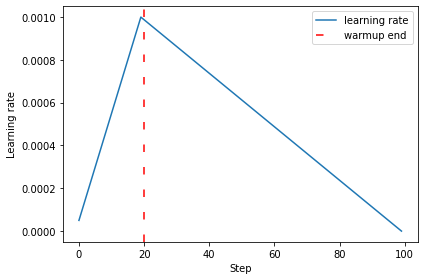

In [16]:
dummy_model = nn.Linear(2, 1)
optimizer = AdamW(params=dummy_model.parameters(), lr=0.001)
warmup_steps = 20
total_training_steps = 100
scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=warmup_steps,num_training_steps=total_training_steps)
learning_rate_history = []

for step in range(total_training_steps):
    optimizer.step()
    scheduler.step()
    learning_rate_history.append(optimizer.param_groups[0]['lr'])

plt.plot(learning_rate_history, label="learning rate")
plt.axvline(x=warmup_steps, color="red", linestyle=(0, (5, 10)), label="warmup end")
plt.legend()
plt.xlabel("Step")
plt.ylabel("Learning rate")
plt.tight_layout();

In [17]:
steps_per_epoch=len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS

In [18]:
warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(1120, 5600)

In [19]:
model = IntentTagger(n_classes=len(LABEL_COLUMNS),n_warmup_steps=warmup_steps,n_training_steps=total_training_steps)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [20]:
criterion = nn.BCELoss()

In [21]:
logger = TensorBoardLogger("IntentQA_logs", name="questions-model")
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)

In [22]:
trainer = pl.Trainer(logger=logger,
                     checkpoint_callback=True,
                     callbacks=[early_stopping_callback],
                     max_epochs=N_EPOCHS,
                     gpus=1,
                     progress_bar_refresh_rate=10)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [23]:
trainer.checkpoint_callback.best_model_path

''

In [24]:
trained_model = IntentTagger.load_from_checkpoint("IntentQA_logs/questions-model/version_5/checkpoints/epoch=10-step=626.ckpt",
                                                  n_classes=len(LABEL_COLUMNS))
trained_model.eval()
trained_model.freeze()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [25]:
print(trainer.checkpoint_callback.best_model_path)

In [26]:
test_comment = "I have 2 options, either invest in gold or in NASDAQ, what should i do?"
encoding = tokenizer.encode_plus(test_comment,
                                 add_special_tokens=True,
                                 max_length=512,
                                 return_token_type_ids=False,
                                 padding="max_length",
                                 return_attention_mask=True,
                                 return_tensors='pt')

_, test_prediction = trained_model(encoding["input_ids"], encoding["attention_mask"])
test_prediction = test_prediction.flatten().numpy()

for label, prediction in zip(LABEL_COLUMNS, test_prediction):
    print(f"{label}: {prediction}")

empty: 0.08006449043750763
how_do_i: 0.44743290543556213
what_are_my_option: 0.30205172300338745
which_is_better: 0.4311736822128296
can_i: 0.2629285752773285
how_much_can_i: 0.04495246708393097
when_do_i: 0.0783689022064209
how_much_do_i: 0.0623934231698513
are_my_concerns_justified: 0.07697169482707977
what_is: 0.06589370220899582
why_should_i: 0.07594060152769089
what_if: 0.10618402063846588


In [27]:
#### evaluation
val_df1 = val_df
val_df = train_df

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)
val_dataset = IntentDataset(val_df, tokenizer,max_token_len=MAX_TOKEN_COUNT)

predictions = []
labels = []

for item in tqdm(val_dataset):
    _, prediction = trained_model(
        item["input_ids"].unsqueeze(dim=0).to(device),
        item["attention_mask"].unsqueeze(dim=0).to(device))
    
    predictions.append(prediction.flatten())
    labels.append(item["labels"].int())

predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()

  0%|          | 0/680 [00:00<?, ?it/s]

In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

In [29]:
labels[:,1]

tensor([0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
        0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
        0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1,
        1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
        0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0,
        0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1,
        0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,

In [30]:
optimal_proba_cutoff = []
for k, name in enumerate(LABEL_COLUMNS):
    false_pos_rate, true_pos_rate, proba = roc_curve(labels[:,k], predictions[:,k])
    optimal_proba_cutoff = optimal_proba_cutoff + [sorted(list(zip(np.abs(true_pos_rate - false_pos_rate), proba)), key=lambda i: i[0], reverse=True)[0][1]]
#     roc_predictions = [1 if i >= optimal_proba_cutoff else 0 for i in predictions[:,0]]
optimal_proba_cutoff

[0.35162783,
 0.3569162,
 0.27272627,
 0.29555503,
 0.16821548,
 0.045978922,
 0.07453671,
 0.05463462,
 0.036762025,
 0.039984822,
 0.048853137,
 0.063589014]

In [31]:
THRESHOLD = 0.3
accuracy(predictions, labels, threshold=THRESHOLD)

/root/Aditya/venv/lib/python3.6/site-packages/deprecate/deprecation.py:115: LightningDeprecationWarning: The `accuracy` was deprecated since v1.3.0 in favor of `torchmetrics.functional.classification.accuracy.accuracy`. It will be removed in v1.5.0.
  stream(template_mgs % msg_args)


tensor(0.8973)

In [32]:
print("AUROC per tag")

for i, name in enumerate(LABEL_COLUMNS):
    print(i)
    try:
        tag_auroc = auroc(predictions[:, i], labels[:, i], pos_label=1)
        print(f"{name}: {tag_auroc}")
    except:
        print(f"{name}:", " no record")
        pass

AUROC per tag
0
empty: 0.9535378813743591
1
how_do_i: 0.8482104539871216
2
what_are_my_option: 0.8802140951156616
3
which_is_better: 0.7803341746330261
4
can_i: 0.702508807182312
5
how_much_can_i: 0.5861654281616211
6
when_do_i: 0.5236634612083435
7
how_much_do_i: 0.6157407164573669
8
are_my_concerns_justified: 0.39923831820487976
9
what_is: 0.4894142746925354
10
why_should_i: 0.694154679775238
11
what_if: 0.5846484303474426


/root/Aditya/venv/lib/python3.6/site-packages/deprecate/deprecation.py:115: LightningDeprecationWarning: The `auroc` was deprecated since v1.3.0 in favor of `torchmetrics.functional.classification.auroc.auroc`. It will be removed in v1.5.0.
  stream(template_mgs % msg_args)


In [33]:
y_pred = predictions.numpy()
y_true = labels.numpy()

upper, lower = 1, 0
THRESHOLD = optimal_proba_cutoff
y_pred = np.where(y_pred > THRESHOLD, upper, lower)

print(classification_report(y_true,y_pred,target_names=LABEL_COLUMNS,
zero_division=0))

                           precision    recall  f1-score   support

                    empty       0.82      0.86      0.84       156
                 how_do_i       0.56      0.71      0.63       158
       what_are_my_option       0.64      0.77      0.70       137
          which_is_better       0.41      0.90      0.56       181
                    can_i       0.22      0.72      0.34        94
           how_much_can_i       0.04      0.60      0.07        15
                when_do_i       0.06      0.25      0.09        28
            how_much_do_i       0.06      0.81      0.11        32
are_my_concerns_justified       0.01      0.22      0.01         9
                  what_is       0.03      0.81      0.06        26
             why_should_i       0.02      0.56      0.04         9
                  what_if       0.07      0.85      0.13        40

                micro avg       0.18      0.78      0.30       885
                macro avg       0.24      0.67      0.30    

In [34]:
### metrics on validation data
#### evaluation

val_df = val_df1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)
val_dataset = IntentDataset(val_df, tokenizer,max_token_len=MAX_TOKEN_COUNT)

predictions = []
labels = []

for item in tqdm(val_dataset):
    _, prediction = trained_model(
        item["input_ids"].unsqueeze(dim=0).to(device),
        item["attention_mask"].unsqueeze(dim=0).to(device))
    
    predictions.append(prediction.flatten())
    labels.append(item["labels"].int())

predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()

  0%|          | 0/121 [00:00<?, ?it/s]

In [35]:
THRESHOLD = 0.3
accuracy(predictions, labels, threshold=THRESHOLD)

tensor(0.9112)

In [36]:
print("AUROC per tag")

for i, name in enumerate(LABEL_COLUMNS):
    try:
        tag_auroc = auroc(predictions[:, i], labels[:, i], pos_label=1)
        print(f"{name}: {tag_auroc}")
    except:
        print(f"{name}:", " no record")
        pass

AUROC per tag
empty: 0.9879084825515747
how_do_i: 0.8999999761581421
what_are_my_option: 0.8342856764793396
which_is_better: 0.7966994047164917
can_i: 0.5662393569946289
how_much_can_i: 0.6807910203933716
when_do_i: 0.3440265357494354
how_much_do_i: 0.5689655542373657
are_my_concerns_justified:  no record
what_is: 0.598870038986206
why_should_i:  no record
what_if: 0.6293103694915771


In [37]:
y_pred = predictions.numpy()
y_true = labels.numpy()

upper, lower = 1, 0
THRESHOLD = optimal_proba_cutoff
y_pred = np.where(y_pred > THRESHOLD, upper, lower)

print(classification_report(y_true,y_pred,target_names=LABEL_COLUMNS,
zero_division=0))

                           precision    recall  f1-score   support

                    empty       0.87      0.92      0.89        36
                 how_do_i       0.62      0.83      0.71        30
       what_are_my_option       0.64      0.67      0.65        21
          which_is_better       0.44      0.91      0.59        32
                    can_i       0.14      0.54      0.23        13
           how_much_can_i       0.04      0.67      0.07         3
                when_do_i       0.00      0.00      0.00         8
            how_much_do_i       0.05      0.80      0.10         5
are_my_concerns_justified       0.00      0.00      0.00         0
                  what_is       0.03      1.00      0.05         3
             why_should_i       0.00      0.00      0.00         0
                  what_if       0.05      0.80      0.09         5

                micro avg       0.19      0.78      0.30       156
                macro avg       0.24      0.59      0.28    